# Model

The ultimate goal of the model is to learn a __latent variable space of musical units__. Then, given a musical unit, we wish to encode that unit into a latent vector within the space, and predict the best accompaninment latent vector to that input. Finally, that accompaniment latent vector can be decoded to produce an accompanying musical unit.

This involves many tricky steps, so development will be approached incrementally:

#### 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

Autoencoding: To test this convolutional autoencoder, generate a response to a given input unit using 
- Decoder reconstruction of same input
- Nearest-neighbor unit selection (Similar to what Bretan et al did)

De-noising: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of
- Decoder reconstruction of "full"/"comp" unit
- Nearest-neighbor unit selection

#### 2. LSTM of latent variables -> Generation using unit selection

Given a sequence of embeddings (from the convolutional autoencoder), predict the next embedding - and perform NN-unit-selection as before, to generate the next unit in the sequence.

#### 3. Convolutional Variational Autoencoder

Learn a new latent space using a VAE architecture. Test how well resconstruction works using
- Decoder reconstruction

#### 4. LSTM of variational latent variables -> Generation using latent space sampling 

Given a sequence of embeddings (from the VAE), predict the next embedding and generate an output musical unit by decoding the predicted embedding!!!


In [2]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

PICKLE_FILE = './pickle_jar/units_50_songs.pkl'

In [3]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )

units["full"] = units["input"] + units["comp"]

# Print info
print "Loaded", units["input"].shape[0], "units from", PICKLE_FILE
print "full_units.shape: ", units["full"].shape
print "input_units.shape: ", units["input"].shape
print "input_units_next.shape: ", units["input_next"].shape
print "comp_units.shape: ", units["comp"].shape
print "comp_units_next.shape: ", units["comp_next"].shape

Loaded 3276 units from ./pickle_jar/units_50_songs.pkl
full_units.shape:  (3276, 96, 128)
input_units.shape:  (3276, 96, 128)
input_units_next.shape:  (3276, 96, 128)
comp_units.shape:  (3276, 96, 128)
comp_units_next.shape:  (3276, 96, 128)


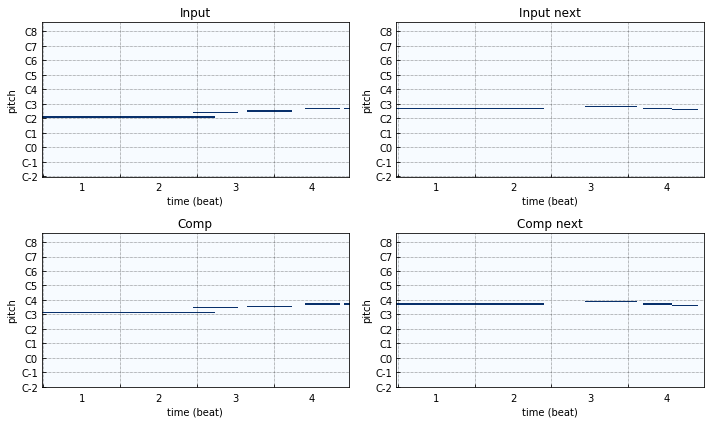

In [5]:

# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(units["input"].shape[0])
pianoroll_utils.plot_four_units(units, unit_index)


In [6]:

# Listen to the MIDI files
# pianoroll_utils.playPianoroll(units["input"][unit_index])
# pianoroll_utils.playPianoroll(units["input_next"][unit_index])
# pianoroll_utils.playPianoroll(units["comp"][unit_index])
# pianoroll_utils.playPianoroll(units["comp_next"][unit_index])

# Listen to the input with the comp
# pianoroll_utils.playPianoroll(units["input"][unit_index] + units["comp"][unit_index])
# pianoroll_utils.playPianoroll(units["input_next"][unit_index] + units["comp_next"][unit_index])

pianoroll_utils.playPianoroll(units["full"][unit_index])

0

In [28]:
import tensorflow as tf
from tensorflow.contrib import rnn # from tensorflow.python.ops import rnn
from tensorflow.contrib import seq2seq # from tensorflow.python.ops import seq2seq

print(tf.__version__)

1.6.0


## 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

### Testing

We will evaluate the autoencoder using two measures:

1. __Autoencoding__: To test this convolutional autoencoder, generate a response to a given input unit using 

    - Decoder reconstruction of same input
    - Nearest-neighbor unit selection (Similar to what Bretan et al did)

2. __De-noising__: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of

    - Decoder reconstruction of "full"/"comp" unit
    - Nearest-neighbor unit selection

    (inspired by Huang et al Counterpoint by Convolution, and Bretan et al Learning and Evaluating Musical Features with Deep Autoencoders)

These two tests simply require training the model on two different datasets: "full"->"full" for autoencoding, and "input"->"comp" for de-noising.

### Architecture




In [34]:
# Start the session
# sess = tf.InteractiveSession()
sess.close()

In [35]:
# # Placeholders for our input data, hidden layer, and y values
# X = tf.placeholder("float", [None, self.time_steps, self.input_size])
# hidden_state = tf.placeholder("float", [None, self.hidden_features], name="Hidden")
# Y = tf.placeholder("float", [None, self.output_classes], name="Output")


In [37]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


In [ ]:
num_encoder_tokens = 100
latent_dim = 100 # Latent dimensionality of the encoding space.

In [38]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


NameError: name 'num_encoder_tokens' is not defined